In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import pickle

### Q1. Downloading the data

Read the data for January. How many records are there?

In [35]:
hire_df = pd.read_parquet("./data/fhv_tripdata_2021-01.parquet")
val_df = pd.read_parquet("./data/fhv_tripdata_2021-02.parquet")

In [4]:
hire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154112 entries, 0 to 1154111
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1154112 non-null  object        
 1   pickup_datetime         1154112 non-null  datetime64[ns]
 2   dropOff_datetime        1154112 non-null  datetime64[ns]
 3   PUlocationID            195845 non-null   float64       
 4   DOlocationID            991892 non-null   float64       
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1153227 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 61.6+ MB


solution: 1154112

### Q2. Computing duration
Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the average trip duration in January?

In [41]:
hire_df['duration'] = hire_df.dropOff_datetime - hire_df.pickup_datetime
td = hire_df.duration.iloc[0]
hire_df['duration'] = hire_df.duration.apply(lambda td: td.total_seconds()/60)
hire_df.duration.mean()

19.1672240937939

In [38]:
val_df['duration'] = val_df.dropOff_datetime - val_df.pickup_datetime
td_val = val_df.duration.iloc[0]
val_df['duration'] = val_df.duration.apply(lambda td_val: td_val.total_seconds()/60)
val_df.duration.mean()

20.70698622520125

### Data preparation
Check the distribution of the duration variable. There are some outliers.

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop?

/home/venkat/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

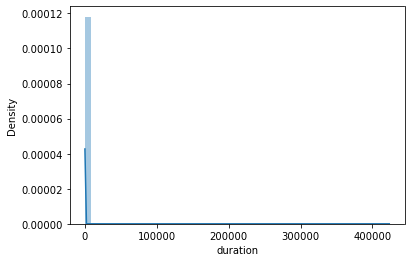

In [43]:
sns.distplot(hire_df.duration)

In [44]:
hire_df_new = hire_df[(hire_df.duration >= 1) & (hire_df.duration <= 60)]
val_df_new = val_df[(val_df.duration >= 1) & (val_df.duration <= 60)]
hire_df_new.duration.count()

1109826

### Q3. Missing values
The features we'll use for our model are the pickup and dropoff location IDs.

But they have a lot of missing values there. Let's replace them with "-1".

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

In [8]:
hire_df_new = hire_df_new.fillna(-1)

In [53]:
val_df_new = val_df_new.fillna(-1)

In [9]:
percent = (hire_df_new.PUlocationID[hire_df_new.PUlocationID == -1].count()/hire_df_new.PUlocationID.count())*100
percent

83.52732770722618

In [54]:
percent_val = (val_df_new.PUlocationID[val_df_new.PUlocationID == -1].count()/val_df_new.PUlocationID.count())*100
percent_val

85.71354986754038

### Q4. One-hot encoding
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

Turn the dataframe into a list of dictionaries
Fit a dictionary vectorizer
Get a feature matrix from it
What's the dimensionality of this matrix? (The number of columns).

In [10]:
features = ["PUlocationID", "DOlocationID"]

In [12]:
df_hire = hire_df_new[features].astype(str)
df_hire.dtypes

PUlocationID    object
DOlocationID    object
dtype: object

In [55]:
df_val = val_df_new[features].astype(str)
df_val.dtypes

PUlocationID    object
DOlocationID    object
dtype: object

In [15]:
train_dict = df_hire[features].to_dict(orient = 'records')
dv = DictVectorizer()
x_train = dv.fit_transform(train_dict)

In [58]:
val_dict = df_val[features].to_dict(orient = 'records')
x_val = dv.transform(val_dict)

In [27]:
# The number of columns
len(dv.feature_names_)

525

### Q5. Training a model
Now let's use the feature matrix from the previous step to train a model.

 - Train a plain linear regression model with default parameters

 - Calculate the RMSE of the model on the training data

What's the RMSE on train?

In [31]:
y_train = hire_df_new["duration"].values

numpy.ndarray

In [59]:
y_val = val_df_new["duration"].values

In [32]:
linear = LinearRegression()
linear.fit(x_train, y_train)

LinearRegression()

In [33]:
y_pred = linear.predict(x_train)
y_pred

array([23.05208497, 23.05208497, 14.10570364, ..., 16.61395942,
       11.13738395, 23.05208497])

In [34]:
mean_squared_error(y_train, y_pred, squared=False)

10.52851910721221

### Q6. Evaluating the model
Now let's apply this model to the validation dataset (Feb 2021).

What's the RMSE on validation?

In [60]:
y_val_pred = linear.predict(x_val)

In [61]:
mean_squared_error(y_val, y_val_pred, squared=False)

11.014283209277062